# Electric Consumption Preprocessing

## 1. Introduction

This notebook handles the entire preprocessing pipeline for our electricity consumption dataset, including:

- **Data Loading**: Importing the raw dataset and setting up the environment for analysis

- **Exploratory Data Analysis (EDA)**: Conducting initial exploration of the data, including:
  - Dataset structure and variable descriptions
  - Conversion of data types to numeric format
  - Creation of a datetime index
  - Analysis of electricity consumption patterns
  - Interactive visualization of temporal trends

- **Data Cleaning**: Addressing missing values and outliers through:
  - Identification of missing data intervals
  - Implementation of a sophisticated imputation strategy
  - Resampling to hourly averages

- **Time Series Analysis**: PACF analysis to understand temporal dependencies

- **Dataset Splitting**: Creating train, validation, and test sets (70%/10%/20%) before imputation

- **Feature Analysis**: Correlation analysis and VIF calculation to assess multicollinearity

- **Additional Feature Engineering**: Adding temporal variables (Hour, DayOfWeek, IsWeekend)

- **Data Export**: Saving the processed datasets for modeling

The final output consists of three clean, ready-to-use datasets for training, validation, and testing our machine learning models, with all preprocessing steps properly documented and implemented.

## 2. Data Loading

In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
from dash import Dash, dcc, html
from dash.dependencies import Input as DashInput, Output as DashOutput
import dash
import threading
import time
from IPython.display import display, clear_output
from IPython.display import display
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter,HourLocator, ConciseDateFormatter
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
# Sets random seeds to ensure result reproducibility (Python, NumPy, TensorFlow, hashing)
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Dataset loading
data = pd.read_csv(
    'data/household_power_consumption.csv',sep=';', low_memory=False)

## 3. Exploratory Data Analysis (EDA)

In [4]:
# Display the first 10 rows
data.head(10)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,5/2/2007,07:38:00,2.376,0.140,241.030,9.800,0.000,0.000,18.0
1,5/2/2007,07:39:00,2.348,0.082,242.470,9.600,0.000,0.000,19.0
2,5/2/2007,07:40:00,2.270,0.000,242.060,9.400,0.000,0.000,18.0
3,5/2/2007,07:41:00,2.304,0.000,242.790,9.400,0.000,0.000,18.0
4,5/2/2007,07:42:00,2.362,0.000,242.350,9.600,0.000,0.000,18.0
5,5/2/2007,07:43:00,2.370,0.000,242.760,9.800,0.000,0.000,18.0
6,5/2/2007,07:44:00,2.336,0.000,242.380,9.600,0.000,0.000,19.0
7,5/2/2007,07:45:00,2.332,0.000,243.000,9.600,0.000,0.000,18.0
8,5/2/2007,07:46:00,2.312,0.000,242.510,9.400,0.000,0.000,18.0
9,5/2/2007,07:47:00,2.316,0.000,242.600,9.600,0.000,0.000,18.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527382 entries, 0 to 1527381
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1527382 non-null  object 
 1   Time                   1527382 non-null  object 
 2   Global_active_power    1527382 non-null  object 
 3   Global_reactive_power  1527382 non-null  object 
 4   Voltage                1527382 non-null  object 
 5   Global_intensity       1527382 non-null  object 
 6   Sub_metering_1         1527382 non-null  object 
 7   Sub_metering_2         1527382 non-null  object 
 8   Sub_metering_3         1519038 non-null  float64
dtypes: float64(1), object(8)
memory usage: 104.9+ MB


This dataset contains **1,527,382 observations** of electrical measurements collected from a household.
The dataset variables are:

- **date**: Date in **DD/MM/YYYY** format

- **time**: Time in **HH:MM:SS** format

- **global_active_power**: Average **global active power** per minute for the household (in **kilowatts**)

- **global_reactive_power**: Average **global reactive power** per minute for the household (in **kilowatts**)

- **voltage**: Average **voltage** per minute (in **volts**)

- **global_intensity**: Average **global electrical current** per minute for the household (in **amperes**)

- **sub_metering_1**: **Sub-metering #1** (in **watt-hours of active energy**). Corresponds to the kitchen, primarily including a dishwasher, oven, and microwave (the stove runs on gas).

- **sub_metering_2**: **Sub-metering #2** (in **watt-hours of active energy**). Corresponds to the laundry room, including a washing machine, dryer, refrigerator, and light.

- **sub_metering_3**: **Sub-metering #3** (in **watt-hours of active energy**). Corresponds to an electric water heater and air conditioner.

The variables "Global_active_power", "Global_reactive_power", "Voltage", "Global_intensity", "Sub_metering_1", "Sub_metering_2", and "Sub_metering_3" must be converted to numeric format.

In [6]:
columns_to_conv = ["Global_active_power","Global_reactive_power","Voltage","Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]      
for col in columns_to_conv:
    data[col] = pd.to_numeric(data[col], errors='coerce')

Replacing the 'Date' and 'Time' columns with the 'Datetime' column in datetime format.

In [7]:
data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str), 
                                  format='%d/%m/%Y %H:%M:%S', 
                                  errors='coerce')

print('Number of missing dates: ',data['Datetime'].isna().sum())

Number of missing dates:  0


There are no missing dates in the data. The 'Datetime' column is used as the DataFrame index.

In [8]:
data.drop(columns=['Date','Time'],axis=1,inplace=True)
data.set_index('Datetime', inplace=True)
data.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2007-02-05 07:38:00,2.376,0.140,241.03,9.8,0.0,0.0,18.0
2007-02-05 07:39:00,2.348,0.082,242.47,9.6,0.0,0.0,19.0
2007-02-05 07:40:00,2.270,0.000,242.06,9.4,0.0,0.0,18.0
2007-02-05 07:41:00,2.304,0.000,242.79,9.4,0.0,0.0,18.0
2007-02-05 07:42:00,2.362,0.000,242.35,9.6,0.0,0.0,18.0
2007-02-05 07:43:00,2.370,0.000,242.76,9.8,0.0,0.0,18.0
2007-02-05 07:44:00,2.336,0.000,242.38,9.6,0.0,0.0,19.0
2007-02-05 07:45:00,2.332,0.000,243.00,9.6,0.0,0.0,18.0
2007-02-05 07:46:00,2.312,0.000,242.51,9.4,0.0,0.0,18.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1527382 entries, 2007-02-05 07:38:00 to 2009-12-31 23:59:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Global_active_power    1519038 non-null  float64
 1   Global_reactive_power  1519038 non-null  float64
 2   Voltage                1519038 non-null  float64
 3   Global_intensity       1519038 non-null  float64
 4   Sub_metering_1         1519038 non-null  float64
 5   Sub_metering_2         1519038 non-null  float64
 6   Sub_metering_3         1519038 non-null  float64
dtypes: float64(7)
memory usage: 93.2 MB


In [10]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1.519038e+06,1.519038e+06,1.519038e+06,1.519038e+06,1.519038e+06,1.519038e+06,1.519038e+06
mean,1.072734e+00,1.216252e-01,2.406292e+02,4.554383e+00,1.154842e+00,1.329133e+00,6.169491e+00
std,1.068330e+00,1.116311e-01,3.303859e+00,4.491518e+00,6.276260e+00,5.921996e+00,8.325753e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.980000e-01,4.600000e-02,2.387300e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.480000e-01,1.000000e-01,2.408300e+02,2.400000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.510000e+00,1.920000e-01,2.427400e+02,6.200000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.200000e+01,7.700000e+01,3.100000e+01


The data reveals an average electrical consumption of approximately 1.07 kW, with high variability (standard deviation ≈ 1.07), a globally stable voltage around 240 V, and sub-meters 1 and 2 often at zero (75th percentile = 0), while Sub_metering_3 shows significant activity (median = 1, max = 31), suggesting concentrated usage on appliances like the water heater or air conditioner.

### Number of missing values per column

In [11]:
data.isnull().sum()

Global_active_power      8344
Global_reactive_power    8344
Voltage                  8344
Global_intensity         8344
Sub_metering_1           8344
Sub_metering_2           8344
Sub_metering_3           8344
dtype: int64

In [12]:
missing_pctg = (data.isnull().sum() * 100 / data.shape[0]).round(2)
print('Percentage of missing data:')
missing_pctg

Percentage of missing data:


Global_active_power      0.55
Global_reactive_power    0.55
Voltage                  0.55
Global_intensity         0.55
Sub_metering_1           0.55
Sub_metering_2           0.55
Sub_metering_3           0.55
dtype: float64

The dataset contains 8,344 missing values per variable, accounting for approximately 0.55% of the total (out of ~1.52 million rows).

### Analysis of electricity consumption patterns

In [13]:
data_saison = data.copy()

In [14]:
data_saison['Year'] = data_saison.index.year   # Colonne de l'année
data_saison['Month'] = data_saison.index.month # Colonne du mois
data_saison['Day'] = data_saison.index.day     # Colonne du jour
data_saison['Hour'] = data_saison.index.hour   # Colonne de l'heure
data_saison['DayOfWeek'] = data_saison.index.day_name() 

In [15]:
def update_graphs(selected_vars):
    """
    Updates the Plotly graph with monthly averages for each variable and year based on the user-selected variables.

    Parameters
    ----------
    selected_vars : list of str
        List of variables to display in the graph.

    Returns
    --------
    plotly.graph_objs.Figure ou dict
        - A Figure object containing monthly trends per year for each selected variable.
        - If no variables are selected, returns a dictionary with an error message to display.
    """
    if not selected_vars:
        return (
            {"layout": {"title": "Please select at least one variable."}},
            {"layout": {"title": "Please select at least one variable."}}
        )

    fig_month = go.Figure() # Monthly graph
    fig_week = go.Figure() # Weekly graph
    fig_day = go.Figure() # Daily graph
    years = sorted(data_saison['Year'].unique()) # Sorted list of years

    for i, var in enumerate(selected_vars):
        for j, year in enumerate(years):
            # Filter data by year
            yearly_data   = data_saison[data_saison['Year'] == year]
            # Average by year
            monthly_avg = yearly_data .groupby('Month')[var].mean()

            # Display data by year
            fig_month.add_trace(go.Scatter(
                x=monthly_avg.index,
                y=monthly_avg.values,
                mode='lines',
                name=f"{var} ({year})",
                line=dict(
                    color=colors[i % len(colors)],
                    dash=['solid', 'dash', 'dot', 'dashdot'][j % 4]
                )
            ))

            # Average by weekday
            weekday_avg = yearly_data .groupby('DayOfWeek')[var].mean()
            fig_week.add_trace(go.Scatter(
                x=list(range(7)),
                y=weekday_avg.values,
                mode='lines',
                name=f"{var} ({year})",
                line=dict(
                    color=colors[i % len(colors)],
                    dash=['solid', 'dash', 'dot', 'dashdot'][j % 4]
                )
            ))

            # Average by hour
            hour_avg = yearly_data .groupby('Hour')[var].mean()
            fig_day.add_trace(go.Scatter(
                x=list(range(24)),
                y=hour_avg.values,
                mode='lines',
                name=f"{var} ({year})",
                line=dict(
                    color=colors[i % len(colors)],
                    dash=['solid', 'dash', 'dot', 'dashdot'][j % 4]
                )
            ))

    fig_month.update_layout(
        title=dict(
            text="Average electricity consumption by month and by year",
            y=0.97,
            x=0.5,
            xanchor='center',
            yanchor='top'
        ),
        xaxis_title="Month",
        yaxis_title="Average value",
        autosize=True,
        margin=dict(t=150),
        xaxis=dict(
            tickmode='array',
            tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        ),
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom", 
            y=1.08,
            xanchor="center",
            x=0.5,
            entrywidth=140,
            font=dict(size=10),
            bgcolor="rgba(255,255,255,0.85)",
            bordercolor="Black",
            borderwidth=0.5
        )
    )

    fig_week.update_layout(
        title=dict(
            text="Average electricity consumption by week and by year",
            y=0.97,
            x=0.5,
            xanchor='center',
            yanchor='top'
        ),
        xaxis_title="Day",
        yaxis_title="Average value",
        autosize=True,
        margin=dict(t=150),
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(7)),
            ticktext=weekday_labels
        ),
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom", 
            y=1.08,
            xanchor="center",
            x=0.5,
            entrywidth=140,
            font=dict(size=10),
            bgcolor="rgba(255,255,255,0.85)",
            bordercolor="Black",
            borderwidth=0.5
        )
    )
    
    fig_day.update_layout(
        title=dict(
            text="Analysis of average daily electricity consumption by hour and by year",
            y=0.97,
            x=0.5,
            xanchor='center',
            yanchor='top'
        ),
        xaxis_title="Hour",
        yaxis_title="Average value",
        autosize=True,
        margin=dict(t=150),
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(24)),
            ticktext=[str(h) for h in range(24)]
        ),
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom", 
            y=1.08,
            xanchor="center",
            x=0.5,
            entrywidth=140,
            font=dict(size=10),
            bgcolor="rgba(255,255,255,0.85)",
            bordercolor="Black",
            borderwidth=0.5
        )
    )

    return fig_month, fig_week, fig_day

In [16]:
variables = ["Global_active_power", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
colors = ['blue', 'green', 'orange', 'purple']
var_labels=["Global_active_power [kW]", "Sub_metering_1 [Wh]", "Sub_metering_2 [Wh]", "Sub_metering_3 [Wh]"]
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Initialization of the Dash application
app = Dash(__name__)

# Layout of the application
app.layout = html.Div([
    html.Div(
        dcc.Checklist(
            id='var-selector',
            options=[{'label': lab, 'value': var} for lab, var in zip(var_labels, variables)],
            value=variables,
            labelStyle={'display': 'inline-block', 'marginRight': '10px'}
        ),
        style={'maxWidth': '100%', 'whiteSpace': 'normal', 'overflowX': 'hidden'}
    ),
    dcc.Graph(id='monthly-graph', style={'height': '600px', 'width': '100%'}),
    dcc.Graph(id='weekday-graph', style={'height': '600px', 'width': '100%'}),
    dcc.Graph(id='hour-graph', style={'height': '600px', 'width': '100%'})
],
style={'overflowX': 'hidden', 'margin': 0, 'padding': 0}
)

# Link between inputs and outputs
app.callback(
    [DashOutput('monthly-graph', 'figure'),
     DashOutput('weekday-graph', 'figure'),
     DashOutput('hour-graph', 'figure')],
    [DashInput('var-selector', 'value')]
)(update_graphs)

def run_dash():
    app.run(port=8052, debug=False, use_reloader=False)

threading.Thread(target=run_dash, daemon=True).start()

time.sleep(1) 

- The analysis of average electricity consumption by month and year shows a seasonal trend with generally higher consumption in winter (January-March and November-December) and lower consumption in summer (July-August) for the three years. Unusual peaks are notable: the consumption in 2007 remains high from February to March, while the year 2008 shows the lowest peak in August, with a drastic and significantly lower drop compared to other years, possibly due to extended vacations. The consumption of sub-meter 3 (water heater and air conditioner) is predominant throughout the year with decreases in July-August and increases in winter, while sub-meters 1 (kitchen) and 2 (laundry) show much lower consumption and less pronounced seasonal variations.

- The analysis of average daily electricity consumption by year shows a decrease at the beginning of the week, especially on Tuesday, abnormal peaks on Wednesday and Thursday, a decrease again on Friday, and an increase on weekends (Saturday and Sunday). There are atypical energy consumption peaks (Global_active_power): a marked peak on Thursday for the year 2007, a peak on Wednesday for the year 2009, and a peak on Saturday for the year 2008, indicating different consumption behavior oriented towards the weekend. The consumption of sub-meter 3 (water heater and air conditioner) is significantly higher and more variable than the others, with a notable peak on Wednesday, while sub-meters 1 (kitchen) and 2 (laundry) show lower consumption levels and less pronounced variations during the week.

- The analysis of average hourly consumption by year shows similar daily trends with a clear morning increase (around 7-9 AM) followed by relative stability or a slight afternoon decrease, followed by a new evening peak (~7-10 PM). The consumption of sub-meter 3 (water heater and air conditioner) is by far the highest, with significant peaks in the morning (around 7-9 AM) and in the evening (around 7-9 PM), while sub-meters 1 (kitchen) and 2 (laundry) show much lower consumption and more moderate peaks.

## 4. Analysis of Missing Data

### Identification of missing data intervals

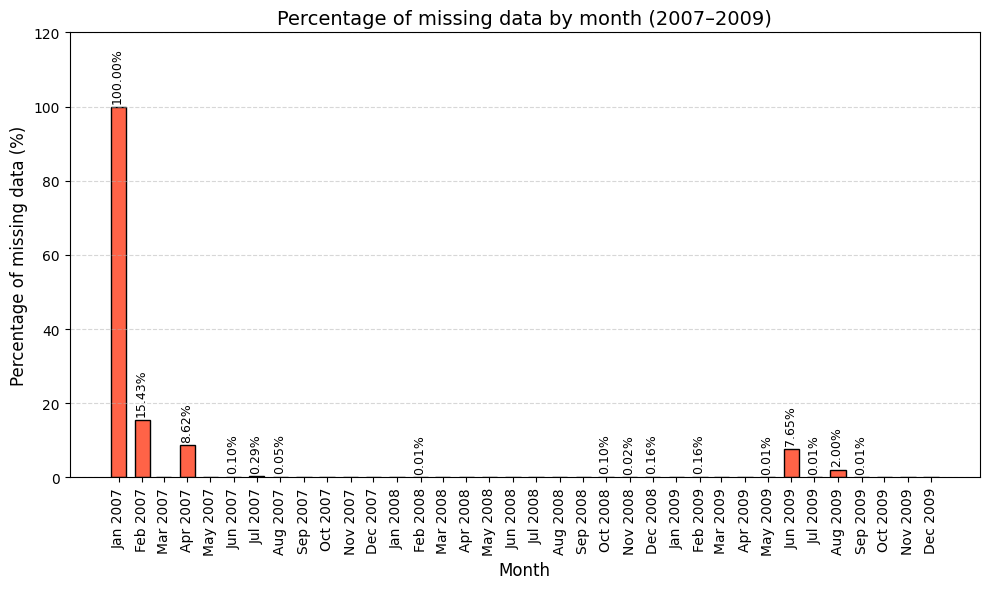

In [17]:
# Generate a complete index
full_range = pd.date_range(start="2007-01-01", end="2009-12-31 23:59", freq="min")
full_df = pd.DataFrame(index=full_range)

# Merge with existing data
joined = full_df.join(data_saison['Global_active_power'], how='left')

# Add Year and Month columns
joined['Year'] = joined.index.year
joined['Month'] = joined.index.month

# Calculate the percentage of missing data by month
expected = joined.groupby(['Year', 'Month']).size()
missing = joined['Global_active_power'].isna().groupby([joined['Year'], joined['Month']]).sum()
missing_percent = (missing / expected * 100).round(2)

# Formatting for display
missing_percent_df = missing_percent.reset_index()
missing_percent_df.columns = ['Year', 'Month', 'MissingPercent']
missing_percent_df['Date'] = pd.to_datetime(
    missing_percent_df['Year'].astype(str) + '-' + missing_percent_df['Month'].astype(str)
)

plt.figure(figsize=(10, 6))
bars = plt.bar(
    missing_percent_df['Date'],
    missing_percent_df['MissingPercent'],
    width=20,  # Largeur des barres
    color='tomato',
    edgecolor='black'
)

plt.title("Percentage of missing data by month (2007–2009)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Percentage of missing data (%)", fontsize=12)
plt.xticks(
    ticks=missing_percent_df['Date'],
    labels=missing_percent_df['Date'].dt.strftime('%b %Y'),
    rotation=90
)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0,120)

for bar in bars:
    height = bar.get_height()
    if height > 0: 
        plt.text(
            bar.get_x(), #+ bar.get_width() / 2,  
            height + 1,  
            f'{height:.2f}%',  
            va='bottom',
            fontsize=9,
            color='black',
            rotation=90
        )
plt.tight_layout()
plt.show()

The analysis of missing data reveals a complete absence of data in January 2007 and partial absence in February 2007, April 2007, June 2009, and August 2009. Overall, the data is very complete in 2008 and for most of 2009.

### Analysis of Missing Data Patterns

In [18]:
# Check for missing values in each column
missing = data.isna()

# Identify the timestamps where there are missing values
missing_rows = missing.any(axis=1)

# Find the continuous intervals of missing values in the index (which is of type datetime)
missing_intervals = []
start = None

for time, is_missing in missing_rows.items():
    if is_missing and start is None:
        start = time
    elif not is_missing and start is not None:
        end = time
        missing_intervals.append((start, end))
        start = None

# If the last value is missing until the end
if start is not None:
    missing_intervals.append((start, data.index[-1]))

# Display the intervals
for start, end in missing_intervals:
    print(f"Intervalle de valeurs manquantes de {start} à {end}")

Intervalle de valeurs manquantes de 2007-02-22 22:58:00 à 2007-02-22 23:00:00
Intervalle de valeurs manquantes de 2007-03-25 17:52:00 à 2007-03-25 17:53:00
Intervalle de valeurs manquantes de 2007-04-28 00:21:00 à 2007-04-30 14:24:00
Intervalle de valeurs manquantes de 2007-06-01 19:14:00 à 2007-06-01 19:15:00
Intervalle de valeurs manquantes de 2007-06-06 21:56:00 à 2007-06-06 21:57:00
Intervalle de valeurs manquantes de 2007-06-09 11:44:00 à 2007-06-09 11:45:00
Intervalle de valeurs manquantes de 2007-06-09 12:05:00 à 2007-06-09 12:06:00
Intervalle de valeurs manquantes de 2007-06-09 17:55:00 à 2007-06-09 17:58:00
Intervalle de valeurs manquantes de 2007-06-09 17:59:00 à 2007-06-09 18:32:00
Intervalle de valeurs manquantes de 2007-06-19 12:14:00 à 2007-06-19 12:16:00
Intervalle de valeurs manquantes de 2007-06-29 09:59:00 à 2007-06-29 10:00:00
Intervalle de valeurs manquantes de 2007-07-15 16:49:00 à 2007-07-15 18:12:00
Intervalle de valeurs manquantes de 2007-07-15 18:21:00 à 2007-0

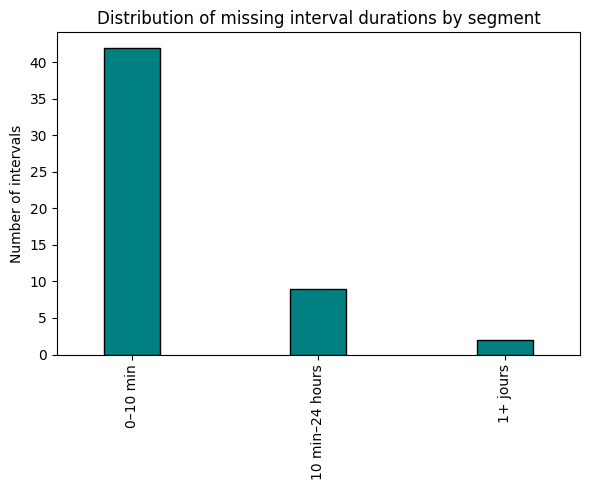

In [19]:
missing_durations = []
for i in range(len(missing_intervals)):
    missing_durations.append(missing_intervals[i][1]-missing_intervals[i][0])
# Convert the Timedelta to minutes
missing_durations_minutes = [d.total_seconds() / 60 for d in missing_durations]

# Definition of thresholds (in minutes) to categorize missing durations
bins = [0, 10, 1440, float('inf')]
labels = ['0–10 min', '10 min–24 hours', '1+ jours']

duration_series = pd.Series(missing_durations_minutes)

# Binning the durations into categories based on defined bins, with labels
duration_categories = pd.cut(duration_series, bins=bins, labels=labels, right=True)
group_counts = duration_categories.value_counts().sort_index()

plt.figure(figsize=(6, 5))
group_counts.plot(kind='bar', width=0.3, color='teal', edgecolor='black')
plt.title("Distribution of missing interval durations by segment")
plt.ylabel("Number of intervals")
plt.tight_layout()
plt.show()

The vast majority of missing data consists of short intervals, with over 40 occurrences of intervals lasting from 0 to 10 minutes. Longer missing intervals are much less frequent, with fewer than 10 occurrences for durations ranging from 10 minutes to 24 hours, and only a few occurrences for intervals lasting more than a day.

### Temporal autocorrelation of daily consumption

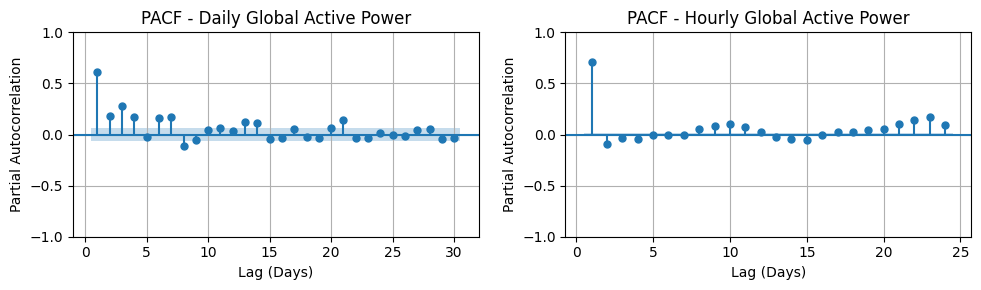

In [20]:
# Resampling with daily and hourly averages
daily_series = data['Global_active_power'].resample('D').mean().dropna()
hourly_series = data['Global_active_power'].resample('h').mean().dropna()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Displaying the partial autocorrelation function for the daily series
plot_pacf(daily_series, lags=30, zero=False, ax=axes[0])
axes[0].set_title("PACF - Daily Global Active Power")
axes[0].set_xlabel("Lag (Days)")
axes[0].set_ylabel("Partial Autocorrelation")
axes[0].grid(True)

# Displaying the partial autocorrelation function for the hourly series
plot_pacf(hourly_series, lags=24, zero=False, method='ywm', ax=axes[1])
axes[1].set_title("PACF - Hourly Global Active Power")
axes[1].set_xlabel("Lag (Days)")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].grid(True)

plt.tight_layout()
plt.show()

The partial autocorrelation function (PACF) graph indicates that past values of a time series directly influence its current value, excluding indirect effects from other lags. The resulting PACF curve shows a significant peak at lag 1, suggesting that the current day's electricity consumption is strongly correlated with the previous day's consumption. This reveals a direct dependence between consecutive days and justifies imputation methods for missing data based on past daily averages.

## 5. Dataset Splitting

Before proceeding with missing value imputation, we split the dataset into training, validation, and test sets with percentages of 70% (training), 10% (validation), and 20% (test). This ensures that only the training set is used to estimate or impute missing values within itself, preventing data leakage.

In [21]:
train_size = int(len(data) * 0.8)
training_df = data.iloc[:train_size]
test_df = data.iloc[train_size:]
# Split train/validation
val_fraction = 0.1
val_size = int(len(training_df) * val_fraction)
val_df = training_df.iloc[-val_size:]    # fin pour la validation
train_df = training_df.iloc[:-val_size]  # tout sauf la fin pour le train

In [22]:
train_df.shape, val_df.shape, test_df.shape

((1099715, 7), (122190, 7), (305477, 7))

## 6. Data Cleaning

### Cleaning strategy for missing data

* **Short Intervals (≤ `threshold_minutes_short`, default: 10 minutes)**
  * Small data gaps are best filled using **local interpolation**, as we expect variations to be gradual. This avoids introducing abrupt changes or biases.

* **Medium Intervals (≤ 1 day = 1440 minutes)**
  * Missing values are estimated using observations from the same time on the previous day. This approach leverages the **daily periodicity** confirmed by partial autocorrelation analysis.

* **Long Intervals (> 1 day)**
  * Missing data is filled using the **average of values at the same time across previous weeks**. This strategy relies on **weekly periodicity**, common in contexts like energy consumption or traffic.
  * If insufficient data is available, the **mean of observed values for the same day of the week, at the same hour and minute**, is used across the entire series.

For **validation and test sets**, the parameter `direction='forward'` is used during imputation to prevent **data leakage from the future**, i.e., values occurring after the time the model is supposed to predict. This ensures the model only uses information available at prediction time, providing a realistic assessment of its performance.

### Implementation of the imputation strategy

In [23]:
def impute_missing_values(data, threshold_minutes_short=10, max_weeks=4, direction='both'):
    """
    Impute missing values in a time-series DataFrame by combining interpolation
    and mean filling based on the time of week.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Time-series data with a DateTimeIndex.
    
    threshold_minutes_short : int
        Maximum duration (in minutes) of a missing interval to be imputed
        using temporal interpolation.
    
    max_weeks : int
        Maximum number of weeks to use for calculating hourly averages
        (by day of week, hour, and minute) for large missing intervals.
    
    direction : str
        Interpolation direction for short intervals: 'both' (training) or 'forward' (validation/test)
    
    Returns:
    --------
    pd.DataFrame
        A copy of the DataFrame with missing values imputed.
    """
    data = data.copy()
    data.sort_index(inplace=True)

    # Identify the missing intervals
    is_missing = data.isnull().any(axis=1)
    missing_intervals = []
    start = None

    for timestamp, missing in is_missing.items():
        if missing and start is None:
            start = timestamp
        elif not missing and start is not None:
            missing_intervals.append((start, timestamp))
            start = None
    if start is not None:
        missing_intervals.append((start, data.index[-1]))

    # Interpolation according to the desired direction
    interpolated = data.interpolate(method='time', limit_direction=direction)

    # Averages by (day of week, hour, minute) — fallback
    fallback_means = (
        data.groupby([data.index.dayofweek, data.index.hour, data.index.minute])
        .mean()
    )

    def get_past_weekly_neighbors_mean(t, col):
        values = []
        for w in range(1, max_weeks + 1):
            past_time = t - pd.Timedelta(weeks=w)
            try:
                val = data.at[past_time, col]
                if not pd.isna(val):
                    values.append(val)
            except KeyError:
                continue
        return np.mean(values) if values else np.nan

    # Imputation based on interval size
    for start, end in missing_intervals:
        gap_minutes = (end - start).total_seconds() / 60
        gap_index = pd.date_range(start, end, freq=data.index.inferred_freq or 'T')

        if gap_minutes <= threshold_minutes_short:
            # Short-range interpolation according to direction
            print(f"Short-range {direction} interpolation: from {start} to {end}")
            for col in data.columns:
                data.loc[gap_index, col] = data.loc[gap_index, col].combine_first(interpolated[col])

        elif gap_minutes <= 1440:
            # Filling with the previous day's data
            print(f"Filling with the previous day's data : {start} to {end}")
            for t in gap_index:
                for col in data.columns:
                    if pd.isna(data.at[t, col]):
                        try:
                            val = data.at[t - pd.Timedelta(days=1), col]
                            if not pd.isna(val):
                                data.at[t, col] = val
                        except KeyError:
                            continue

        else:
            # Filling with the same time slots from previous weeks
            print(f"Filling with the same time slots from previous weeks : {start} to {end}")
            for t in gap_index:
                for col in data.columns:
                    if pd.isna(data.at[t, col]):
                        val = get_past_weekly_neighbors_mean(t, col)
                        if not pd.isna(val):
                            data.at[t, col] = val
                        else:
                            key = (t.dayofweek, t.hour, t.minute)
                            if key in fallback_means.index:
                                data.at[t, col] = fallback_means.at[key, col]

    return data

In [24]:
# Imputation for the training set
train_df = impute_missing_values(train_df, direction='both')

Short-range both interpolation: from 2007-02-22 22:58:00 to 2007-02-22 23:00:00
Short-range both interpolation: from 2007-03-25 17:52:00 to 2007-03-25 17:53:00
Filling with the same time slots from previous weeks : 2007-04-28 00:21:00 to 2007-04-30 14:24:00
Short-range both interpolation: from 2007-06-01 19:14:00 to 2007-06-01 19:15:00
Short-range both interpolation: from 2007-06-06 21:56:00 to 2007-06-06 21:57:00
Short-range both interpolation: from 2007-06-09 11:44:00 to 2007-06-09 11:45:00
Short-range both interpolation: from 2007-06-09 12:05:00 to 2007-06-09 12:06:00
Short-range both interpolation: from 2007-06-09 17:55:00 to 2007-06-09 17:58:00
Filling with the previous day's data : 2007-06-09 17:59:00 to 2007-06-09 18:32:00
Short-range both interpolation: from 2007-06-19 12:14:00 to 2007-06-19 12:16:00
Short-range both interpolation: from 2007-06-29 09:59:00 to 2007-06-29 10:00:00
Filling with the previous day's data : 2007-07-15 16:49:00 to 2007-07-15 18:12:00
Filling with the p

In [25]:
missing_after = train_df[train_df.isnull().any(axis=1)]
print("Number of missing data points in the training set after imputation: ",len(missing_after))

Number of missing data points in the training set after imputation:  0


In [26]:
# Imputation for the validation set (forward fill only = no data leakage from the future)
val_df = impute_missing_values(val_df, direction='forward')

Short-range forward interpolation: from 2009-03-16 21:27:00 to 2009-03-16 21:28:00
Short-range forward interpolation: from 2009-04-13 18:54:00 to 2009-04-13 18:56:00
Short-range forward interpolation: from 2009-05-10 18:00:00 to 2009-05-10 18:01:00
Short-range forward interpolation: from 2009-05-26 04:43:00 to 2009-05-26 04:46:00


In [27]:
missing_after = val_df[val_df.isnull().any(axis=1)]
print("Number of missing data points in the validation set after imputation: ",len(missing_after))

Number of missing data points in the validation set after imputation:  0


In [28]:
# Imputation for the test set (forward fill only = no data leakage from the future)
test_df = impute_missing_values(test_df, direction='forward')

Filling with the same time slots from previous weeks : 2009-06-13 00:30:00 to 2009-06-15 07:35:00
Short-range forward interpolation: from 2009-07-10 22:28:00 to 2009-07-10 22:32:00
Filling with the previous day's data : 2009-08-13 05:00:00 to 2009-08-13 19:51:00
Short-range forward interpolation: from 2009-09-13 18:35:00 to 2009-09-13 18:36:00
Short-range forward interpolation: from 2009-09-30 08:48:00 to 2009-09-30 08:50:00
Short-range forward interpolation: from 2009-10-11 17:07:00 to 2009-10-11 17:08:00
Short-range forward interpolation: from 2009-11-09 20:39:00 to 2009-11-09 20:40:00
Short-range forward interpolation: from 2009-12-10 08:26:00 to 2009-12-10 08:28:00


In [29]:
missing_after = test_df[test_df.isnull().any(axis=1)]
print("Number of missing data points in the test set after imputation: ",len(missing_after))

Number of missing data points in the test set after imputation:  0


### Resampling to hourly averages

We proceed with the aggregation of data at an hourly frequency as this allows us to smooth out minute-by-minute variations and reduce the temporal dimensionality by averaging the values for each hour.

In [30]:
# Resample
train_df = train_df.resample('h').mean()
val_df = val_df.resample('h').mean()
test_df = test_df.resample('h').mean()

print("Dimensions of train_df :", train_df.shape)
print("Dimensions of val_df   :", val_df.shape)
print("Dimensions of test_df  :", test_df.shape)

Dimensions of train_df : (18330, 7)
Dimensions of val_df   : (2037, 7)
Dimensions of test_df  : (5092, 7)


## 7. Feature Analysis

### Correlation analysis of electricity consumption variables

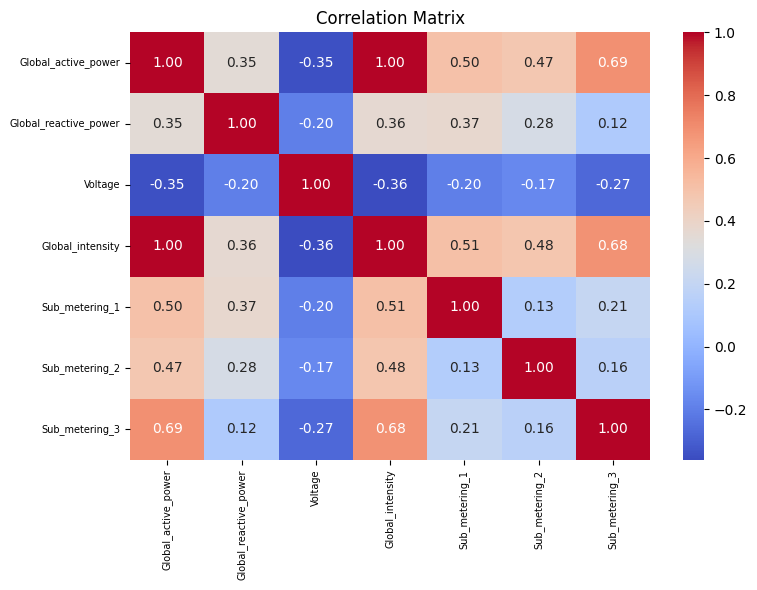

In [31]:
corr_matrix = train_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

The correlation analysis between variables shows that:
- **Global_active_power** is strongly correlated with **Sub_metering_3** (0.69), as is **Global_intensity** (1), indicating that this sub-meter explains a significant portion of the global active power.
- There is also a moderate correlation between **Global_active_power** and **Sub_metering_1** (0.50) as well as with **Sub_metering_2** (0.47), suggesting that these sub-meters also contribute significantly to total consumption.
- **Voltage** shows a moderate negative correlation with **Global_intensity** (-0.36) and with the sub-meters, which is consistent with a possible inverse relationship between voltage and measured consumption.

### Variance Inflation Factors (VIF) analysis

In [32]:
X = train_df[['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                variable          VIF
0                  const  6790.155602
1  Global_reactive_power     1.279260
2                Voltage     1.159981
3       Global_intensity     3.805518
4         Sub_metering_1     1.577563
5         Sub_metering_2     1.501686
6         Sub_metering_3     2.214180


All VIF values are below 5, so there are no multicollinearity issues and consequently we keep all variables.    

## 8. Additional Feature Engineering

We enhance the data by adding three temporal variables: the hour of the day (Hour), the day of the week (DayOfWeek), and a binary indicator (IsWeekend) identifying weekends, in order to capture cyclical effects and behavioral variations in energy consumption.

In [33]:
for df in [train_df,val_df, test_df]: 
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
train_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Hour,DayOfWeek,IsWeekend
Datetime,,,,,,,,,,
2007-02-05 07:00:00,2.423818,0.017545,241.085909,10.027273,0.000000,0.045455,17.909091,7,0,0
2007-02-05 08:00:00,2.985333,0.144133,238.209167,12.573333,14.933333,0.633333,17.400000,8,0,0
2007-02-05 09:00:00,1.360033,0.056567,238.423500,5.640000,0.000000,0.000000,17.416667,9,0,0
2007-02-05 10:00:00,1.358667,0.114467,236.887667,5.716667,0.000000,0.566667,16.766667,10,0,0
2007-02-05 11:00:00,0.301833,0.056800,238.028000,1.283333,0.000000,0.050000,0.000000,11,0,0


## 9. Data Export

In [34]:
# Save the split data to CSV files
train_df.to_csv('data/train_df.csv', index=True)
val_df.to_csv('data/val_df.csv', index=True)
test_df.to_csv('data/test_df.csv', index=True)

print("Preprocessing completed successfully!")

Preprocessing completed successfully!


We enhance the data by adding three temporal variables: the hour of the day (Hour), the day of the week (DayOfWeek), and a binary indicator (IsWeekend) identifying weekends, in order to capture cyclical effects and behavioral variations in energy consumption.

In [35]:
for df in [train_df,val_df, test_df]: 
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
train_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Hour,DayOfWeek,IsWeekend
Datetime,,,,,,,,,,
2007-02-05 07:00:00,2.423818,0.017545,241.085909,10.027273,0.000000,0.045455,17.909091,7,0,0
2007-02-05 08:00:00,2.985333,0.144133,238.209167,12.573333,14.933333,0.633333,17.400000,8,0,0
2007-02-05 09:00:00,1.360033,0.056567,238.423500,5.640000,0.000000,0.000000,17.416667,9,0,0
2007-02-05 10:00:00,1.358667,0.114467,236.887667,5.716667,0.000000,0.566667,16.766667,10,0,0
2007-02-05 11:00:00,0.301833,0.056800,238.028000,1.283333,0.000000,0.050000,0.000000,11,0,0
